# Lognormal density-split model vs. AbacusSummit dark matter simulations in redshift space

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

plots_dir = '/feynman/home/dphp/mp270220/plots'

2024-05-13 14:16:42.372257: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rhel-8.x86_64/gnu9/hdf5/1.10.8/lib:/opt/rhel-8.x86_64/modulefiles/gsl/26/lib:/datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-05-13 14:16:42.372293: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

# Legendre multipoles
ells = [0, 2, 4]

## Average density

In [4]:
abacus_nbar003 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003.npy'.format(z))

## Gaussian model

In [5]:
model_linear = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=False)
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


In [6]:
bg = cosmology.get_background(engine='class')
f = bg.growth_rate(z)
bias = 1.
beta = f / bias
kaiser_boost = np.array([1 + 2 * beta /3 + beta**2 /5., 4. * beta /3 + 4. * beta**2 /7., 8. * beta**2 / 35])

In [7]:
mu = np.linspace(-1, 1, 201)
pk_rsd = (1 + f * mu**2)**2 * model.pk(model.k)[:, None]

In [8]:
pk_rsd.shape

(100000, 201)

In [9]:
model_xi_RSD = kaiser_boost[:, None] * model.xi.flatten().real

In [10]:
def to_poles(pkmu, ells):
    return np.array([(2*ell + 1)/2. * np.trapz(pkmu * scipy.special.legendre(ell)(mu), x=mu, axis=1) for ell in ells])

def pk_model_poles(pk_rsd, ells):
    """
    Computes multipoles of the model from smoothed power spectrum pk_smooth and original power spectrum pk, for a given array of scales k
    """
    poles = to_poles(pk_rsd, ells)
    return poles

In [11]:
pk_model = pk_model_poles(pk_rsd, ells)

In [12]:
sep, xi = PowerToCorrelation(model.k, ell=ells, complex=False)(pk_model)
xi_ells_RSD = np.array([CorrelationFunctionInterpolator1D(sep[ill], xi=xi[ill]) for ill in range(len(ells))])

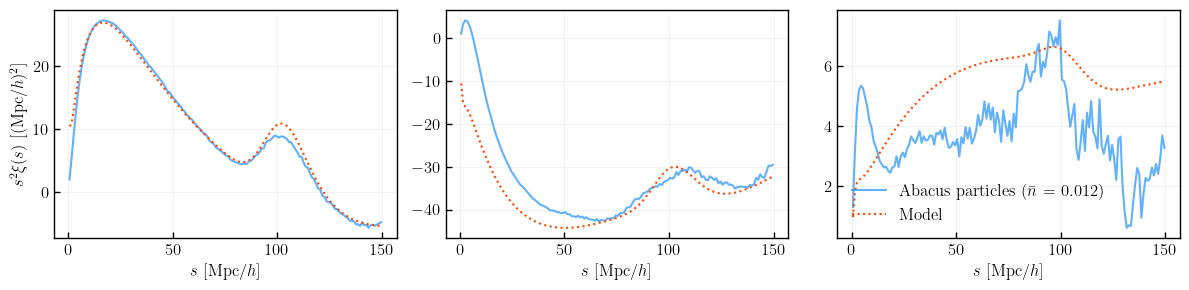

In [13]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_abacus_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_2PCF_RSD.npy'.format(z), allow_pickle=True)
s, xi_ells_abacus_nbar003 = xi_abacus_nbar003.item().get_corr(ells=ells, return_sep=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(s, s**2 * xi_ells_abacus_nbar003[ill], label=r'Abacus particles ($\bar{n}$ = 0.012)', color='C0', alpha=0.7)
    #axes[ill].plot(model_linear.sep.flatten(), model_linear.sep.flatten()**2 * model_xi_RSD[ill], label=r'Model', ls=':', color='C1')
    axes[ill].plot(s, s**2 * xi_ells_RSD[ill](s), label=r'Model', ls=':', color='C1')
    axes[ill].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    
axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()
plt.show()

## Shot noise

In [14]:
# shot noise correction for xi_R
wfield = model.smoothing_kernel_3D.c2r() / model.boxsize**3
sep, mu, w = project_to_basis(wfield, edges=(model.s, np.array([-1., 1.])), exclude_zero=False)[0][:3]
shotnoise_nbar003 = np.real(w / (abacus_nbar003.size/boxsize**3))

# shot noise correction for sigma_RR
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)
shotnoise_sigma_nbar003 = w2 / (abacus_nbar003.size/boxsize**3)

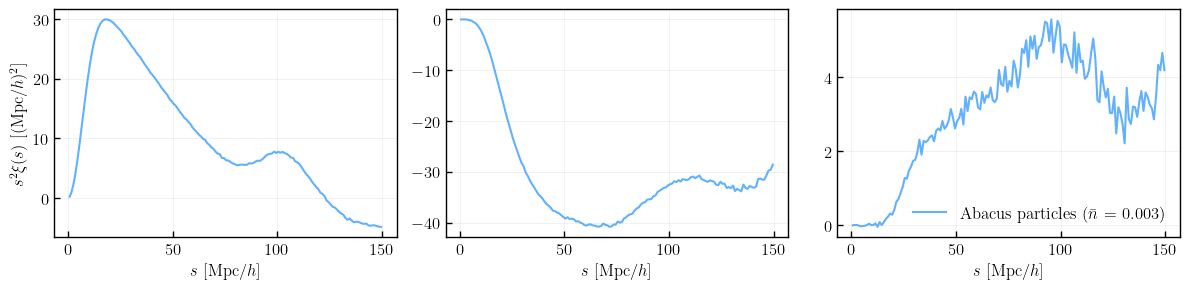

In [15]:
# Abacus smoothed 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_xi_R_RSD.npy'.format(cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_nbar003 = xiR_abacus_nbar003.item().get_corr(ells=ells, return_sep=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(sep, sep**2 * xiR_ells_abacus_nbar003[ill], label=r'Abacus particles ($\bar{n}$ = 0.003)', color='C0', alpha=0.7)
    axes[ill].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    
axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()
plt.show()

In [16]:
abacus_halos_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

In [17]:
abacus_halos_delta_R_RSD = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_ph000_cellsize{:d}_resampler{}_delta_R_RSD.npy'.format(z, cellsize, resampler))

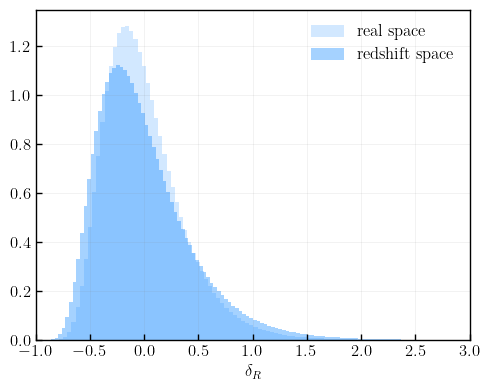

In [18]:
abacus_particles_nbar003_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar003_delta_R_RSD = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R_RSD.npy'.format(z, cellsize, resampler))

plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'real space')
plt.hist(abacus_particles_nbar003_delta_R_RSD, bins=200, density=True, alpha=0.4, color='C0', label=r'redshift space')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

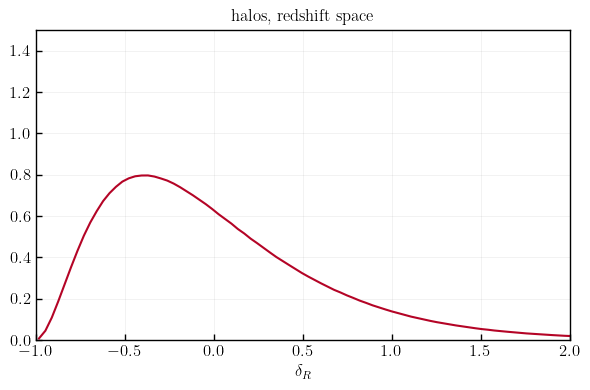

In [19]:
cmap = plt.get_cmap('coolwarm', 5)
colors = [cmap(i) for i in range(5)]

plt.rcParams["figure.figsize"] = (6, 4)

#delta = np.linspace(-1, 3, 100)
#plt.plot(delta, scipy.stats.norm.pdf(delta, 0, model.sigma_RR[0]), color=colors[2], label='Gaussian')
#vals, bins = np.histogram(abacus_particles_nbar003_delta_R, bins=200, density=True)
#plt.plot((bins[1:]+bins[:-1])/2, vals, color=colors[1], label='dark matter, real space')
#vals, bins = np.histogram(abacus_particles_nbar003_delta_R_RSD, bins=200, density=True)
#plt.plot((bins[1:]+bins[:-1])/2, vals, color=colors[0], label='dark matter, redshift space')
#vals, bins = np.histogram(abacus_halos_delta_R, bins=200, density=True)
#plt.plot((bins[1:]+bins[:-1])/2, vals, color=colors[3], label='halos, real space')
vals, bins = np.histogram(abacus_halos_delta_R_RSD, bins=200, density=True)
plt.plot((bins[1:]+bins[:-1])/2, vals, color=colors[4], label='halos, redshift space')
plt.title('halos, redshift space')
plt.ylim(0, 1.5)
plt.xlim(-1, 2.)
plt.xlabel(r'$\delta_R$')
#plt.legend()
plt.show()

In [20]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0_nbar003, sigma_nbar003 = compute_delta0_sigma_from_moments(abacus_particles_nbar003_delta_R)
delta0_nbar003_RSD, sigma_nbar003_RSD = compute_delta0_sigma_from_moments(abacus_particles_nbar003_delta_R_RSD)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2987382549221138e-11
        x: [ 9.711e-01]
      nit: 4
      jac: [ 4.803e-07]
 hess_inv: [[ 1.174e+02]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0905032876253798e-09
        x: [ 1.059e+00]
      nit: 4
      jac: [-8.017e-06]
 hess_inv: [[ 3.101e+01]]
     nfev: 12
     njev: 6


In [21]:
print(delta0_nbar003, sigma_nbar003)
print(delta0_nbar003_RSD, sigma_nbar003_RSD)

0.9711193674625868 0.3661967062628833
1.058828572586203 0.4018351238250601


In [22]:
np.sqrt(np.mean(abacus_particles_nbar003_delta_R_RSD**2))

0.4432420364447809

In [23]:
## Kaiser boost
(1 + 2 * beta /3 + beta**2 /5.)*np.mean(abacus_particles_nbar003_delta_R**2)

0.22999099748776813

In [24]:
sigma_nbar003_RSD_2 = np.sqrt((1 + 2 * beta /3 + beta**2 /5.)*model_linear.sigma_RR**2 + shotnoise_sigma_nbar003)
print(sigma_nbar003_RSD_2)

[0.45585424]


In [25]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

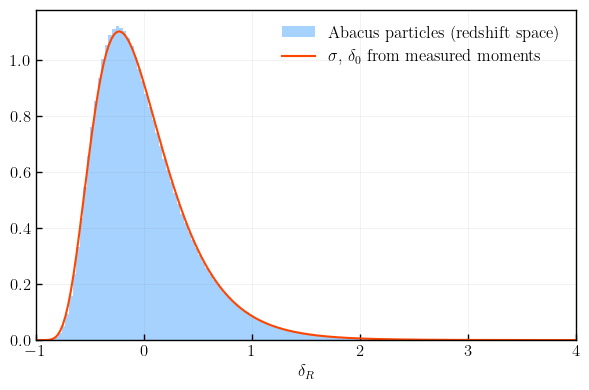

In [26]:
pdf_nbar003 = plt.hist(abacus_particles_nbar003_delta_R_RSD, bins=200, density=True, alpha=0.4, color='C0', label=r'Abacus particles (redshift space)')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD, delta0_nbar003_RSD), color='C1', ls='-', label=r'$\sigma$, $\delta_0$ from measured moments')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
#plt.yscale('log')
#plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.014634042584124074
        x: [ 9.473e-01]
      nit: 5
      jac: [ 6.352e-06]
 hess_inv: [[ 1.498e-02]]
     nfev: 14
     njev: 7


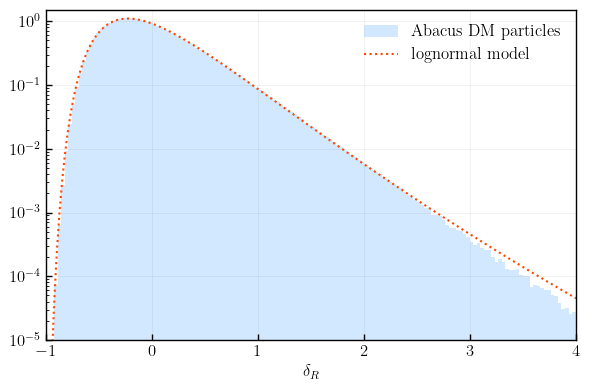

In [27]:
def to_minimize(delta0, *args):
    shotnoise = args[2]
    sigma = np.sqrt((1 + 2 * beta /3 + beta**2 /5.)*model_linear.sigma_RR**2 + shotnoise)
    x = args[0]
    y = friedrich_lognormal_model((args[1][1:]+args[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0(delta_R_pdf, return_sigma=True, shotnoise=0):
    res = minimize(to_minimize, x0=0.9, args=(delta_R_pdf[0], delta_R_pdf[1], shotnoise))
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt((1 + 2 * beta /3 + beta**2 /5.)*model_linear.sigma_RR**2 + shotnoise)
    return delta0, sigma
    
delta0_nbar003_RSD_2, sigma_nbar003_RSD_2 = compute_bestfit_delta0(pdf_nbar003, shotnoise=shotnoise_sigma_nbar003)

plt.hist(abacus_particles_nbar003_delta_R_RSD, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus DM particles')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD, delta0_nbar003_RSD), color='C1', ls=':', label=r'lognormal model')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD_2, delta0_nbar003_RSD_2), color='C1', ls='--', label=r'$\sigma$ from theory, $\delta_0$ fitted')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00032587725141698887
        x: [ 1.007e+00  4.232e-01]
      nit: 16
      jac: [-7.430e-08 -2.257e-07]
 hess_inv: [[ 1.684e-01 -7.501e-02]
            [-7.501e-02  3.731e-02]]
     nfev: 69
     njev: 23


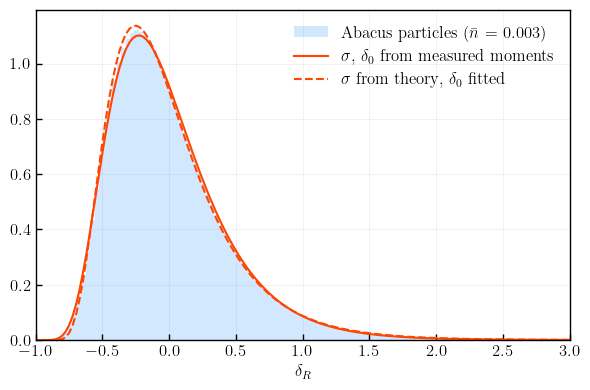

In [28]:
def to_minimize(params, *args):
    pdf = args
    delta0 = params[0]
    sigma = params[1]
    x = pdf[0]
    y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0_sigma(delta_R_pdf):
    res = minimize(to_minimize, x0=np.array([0.9, model.sigma_RR[0]]), args=delta_R_pdf)
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    return delta0, sigma
    
delta0_nbar003_RSD_3, sigma_nbar003_RSD_3 = compute_bestfit_delta0_sigma(pdf_nbar003)

plt.hist(abacus_particles_nbar003_delta_R_RSD, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.003)')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD, delta0_nbar003_RSD), color='C1', ls='-', label=r'$\sigma$, $\delta_0$ from measured moments')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD_2, delta0_nbar003_RSD_2), color='C1', ls='--', label=r'$\sigma$ from theory, $\delta_0$ fitted')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_RSD_3, delta0_nbar003_RSD_3), color='C1', ls=':', label=r'$\sigma$, $\delta_0$ fitted')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
#plt.yscale('log')
#plt.ylim((0.001, 1.2))
plt.legend()
plt.show()

In [29]:
th_bins = scipy.stats.lognorm.ppf([0, 1./3, 2./3, 1], sigma_nbar003_RSD, -delta0_nbar003_RSD, delta0_nbar003_RSD*np.exp(-sigma_nbar003_RSD**2/2.))
th_bins

array([-1.05882857, -0.23735369,  0.10243512,         inf])

## Lognormal model for density splits

In [30]:
th_bins = np.array([-1., -0.23735369,  0.10243512, np.inf])

In [31]:
nsplits = 3

In [32]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

In [33]:
def compute_dsplits_mutlipoles(mu, dsplits, ells=[0, 2, 4]):
    res = list()
    for ds in range(len(dsplits)):
        res_ds = [(2*ell + 1)/2. * np.trapz(dsplits[ds] * scipy.special.legendre(ell)(mu), x=mu, axis=1) for ell in ells]
        res.append(res_ds)
    return res

In [34]:
mu = (xi_abacus_nbar003.item().edges[1][1:] + xi_abacus_nbar003.item().edges[1][:-1])/2.
dsplits = compute_dsplits(sigma=sigma_nbar003_RSD, delta0=1., delta0_R=delta0_nbar003_RSD, bias=1., xi_R=xiR_abacus_nbar003.item()(), shotnoise=shotnoise_nbar003)
dsplits_2 = compute_dsplits(sigma=sigma_nbar003_RSD_2, delta0=1., delta0_R=delta0_nbar003_RSD_2, bias=1., xi_R=xiR_abacus_nbar003.item()(), shotnoise=shotnoise_nbar003)

/tmp/ipykernel_2242950/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_2242950/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


In [35]:
dsplits_RSD = compute_dsplits_mutlipoles(mu, dsplits, ells=ells)
dsplits_RSD_2 = compute_dsplits_mutlipoles(mu, dsplits_2, ells=ells)

In [36]:
cmap = plt.get_cmap('coolwarm', nsplits)
colors = [cmap(i) for i in range(nsplits)]
colors[1]='grey'

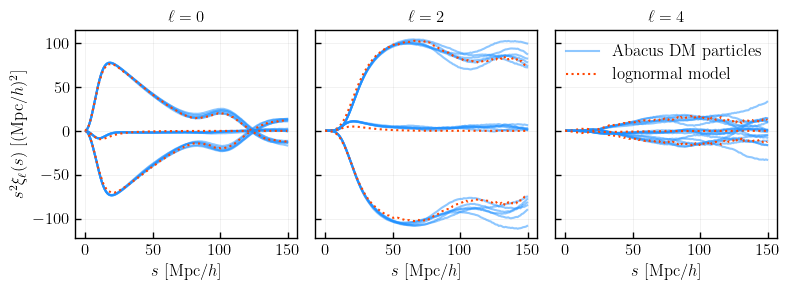

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        for i in range(6):
            split_xi_abacus_particles_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_ph0{:02d}_downsampled_particles_nbar0.0034_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(i, cellsize, resampler, nsplits)+'_RH_CCF_RSD.npy', allow_pickle=True)
            split_xi_abacus_particles_nbar003 = split_xi_abacus_particles_nbar003.item()['rh']
            split_xi_ells_abacus_particles_nbar003 = [split_xi_abacus_particles_nbar003[ds].get_corr(ells=ells) for ds in range(nsplits)]
            sep, _ = split_xi_abacus_particles_nbar003[0].get_corr(ells=ells, return_sep=True)


            axes[ill].plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar003[ds][ill], ls='-', color='C0', alpha=0.5, label='Abacus DM particles' if (ds==0) & (i==0) & (ill==2) else '')
        axes[ill].plot(model.sep.flatten(), model.sep.flatten()**2 * dsplits_RSD[ds][ill], ls=':', color='C1', alpha=1, label=r'lognormal model' if ds==0 else '')
        #axes[ill].plot(model.sep.flatten(), model.sep.flatten()**2 * dsplits_RSD_2[ds][ill], ls='--', color='C1', alpha=1, label=r'Model (theory $\sigma$)' if ds==0 else '')
        axes[ill].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
        axes[ill].set_title(r'$\ell = {}$'.format(ell))
    
axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'lognormalmodel_abacus_dm_particles_densitysplits_rsd.pdf'), dpi=300)
plt.show()